In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, ShuffleSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import time

In [11]:

def train_evaluate_xgb_by_market(data, markets, target_col='avgPrice'):
    for market in markets:
        print(f"Analyzing market: {market}")
        
        # Filter data for the current market
        market_data = data[data['market'] == market]
        
        # Preprocess data
        X = market_data.drop(['date', 'market', target_col], axis=1)
        y = market_data[target_col]
        
        # Define hyperparameter grid
        xgb_params = {
            'n_estimators': [500],
            'max_depth': [6, 8],
            'learning_rate': [0.01, 0.05],
            'min_child_weight': [1, 3],
            'subsample': [0.8, 0.9],
            'colsample_bytree': [0.8, 0.9],
            'gamma': [0, 0.1]
        }
        
        # Set up time series cross-validation
        cv = TimeSeriesSplit(n_splits=5, test_size=len(X)//10)
        
        # Train XGBoost model and evaluate
        xgb = XGBRegressor(random_state=1030, n_jobs=-1)
        grid_search = GridSearchCV(xgb, xgb_params, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
        start_time = time.time()
        grid_search.fit(X, y)
        training_time = time.time() - start_time
        
        # Print model performance
        print(f"Best RMSE: {-grid_search.best_score_:.4f}")
        print("Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"{param}: {value}")
        
        # Predict and visualize
        y_pred = grid_search.predict(X)
        plt.figure(figsize=(15, 7))
        plt.plot(market_data['date'], y, label='Actual', color='blue')
        plt.plot(market_data['date'], y_pred, label='Predicted', color='red', linestyle='--')
        plt.title(f"Actual vs Predicted Price ({market})")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Calculate and print final metrics
        metrics = calculate_metrics(y, y_pred, training_time)
        print("\nFinal Metrics:")
        for k, v in metrics.items():
            print(f"{k}: {v:.4f}")

        print("-" * 50)

def calculate_metrics(y_true, y_pred, training_time):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Training_Time': training_time
    }


In [12]:

# Example usage
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_oneHot.csv')
markets = data['market'].unique()
train_evaluate_xgb_by_market(data, markets)

KeyError: 'market'

In [13]:

def calculate_metrics(y_true, y_pred, training_time):
    """평가 지표 계산 함수"""
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'RMSLE': np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred))),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'Training_Time': training_time
    }

def train_evaluate_xgb(data, target_col='avgPrice', time_series=True):
    """XGBoost 모델 학습 및 평가 함수"""
    # 데이터 전처리
    data['date'] = pd.to_datetime(data['date'])
    X = data.drop(['date', 'item', target_col], axis=1)
    y = data[target_col]

    # 하이퍼파라미터 그리드 정의
    xgb_params = {
        'n_estimators': [500],
        'max_depth': [4, 8],
        'learning_rate': [0.01, 0.05],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'gamma': [0, 0.1]
    }

    # 교차 검증 방식 설정
    if time_series:
        test_size = len(X)//10
        cv = TimeSeriesSplit(n_splits=5, test_size=test_size)
    else:
        cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # 모델 및 그리드서치 설정
    xgb = XGBRegressor(random_state=1030, n_jobs=-1)
    grid_search = GridSearchCV(
        xgb, xgb_params,
        cv=cv,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        verbose=1
    )

    # 모델 학습
    start_time = time.time()
    grid_search.fit(X, y)
    training_time = time.time() - start_time

    # 결과 출력
    print("\n** Model Performance **")
    print(f"Best RMSE: {-grid_search.best_score_:.4f}")
    print("\nBest Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"{param}: {value}")

    # 예측 및 시각화
    y_pred = grid_search.predict(X)
    plt.figure(figsize=(15, 7))
    plt.plot(data['date'], y, label='Actual', color='blue')
    plt.plot(data['date'], y_pred, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # 최종 메트릭 계산 및 출력
    metrics = calculate_metrics(y, y_pred, training_time)
    print("\nFinal Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return grid_search.best_estimator_



Fitting 5 folds for each of 64 candidates, totalling 320 fits

** Model Performance **
Best RMSE: 1385.5880

Best Parameters:
colsample_bytree: 0.9
gamma: 0
learning_rate: 0.01
max_depth: 6
min_child_weight: 3
n_estimators: 500
subsample: 0.8


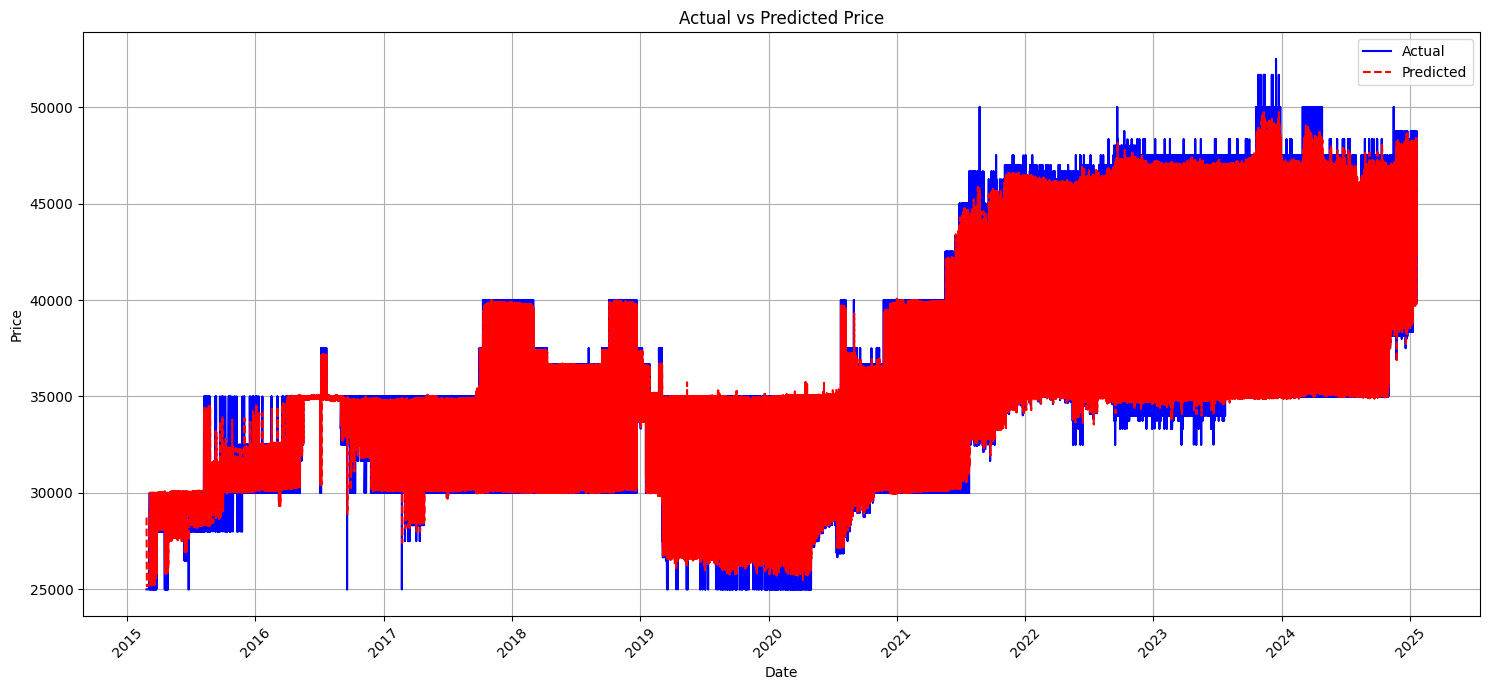


Final Metrics:
MAE: 313.8939
MSE: 419784.1917
RMSE: 647.9075
R2: 0.9827
RMSLE: 0.0180
MAPE: 0.8774
Training_Time: 557.8280


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=-1,
             num_parallel_tree=None, random_state=1030, ...)

In [14]:
data = pd.read_csv('../../../data/features/final_oneHot/광어_price_features_oneHot.csv')
train_evaluate_xgb(data, target_col='avgPrice', time_series=True)

In [6]:
# 결과 저장 함수 추가
def save_results(model, metrics, params, suffix):
    """모델 결과 저장"""
    pd.DataFrame([metrics]).to_csv(f'xgb_{suffix}_results.csv')
    pd.DataFrame([params]).to_csv(f'xgb_{suffix}_best_params.csv')